In [36]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats
from os import listdir


In [49]:
#phase_dir = '../phased_ihart.ms2_del'
#twins_file = 'ihart.ms2_del_identicals.txt'           
#sim_file = 'ihart.ms2_del_similarity.txt'           

#phase_dir = '../phased_ihart.ms2_quads_del'
#twins_file = 'ihart.ms2_quads_del_identicals.txt'           
#sim_file = 'ihart.ms2_quads_del_similarity.txt'           

#phase_dir = '../phased_spark_del'
#twins_file = 'spark_del_identicals.txt'           
#sim_file = 'spark_del_similarity.txt'    

#phase_dir = '../phased_spark_quads_del'
#twins_file = 'spark_quads_del_identicals.txt'           
#sim_file = 'spark_quads_del_similarity.txt'  


#phase_dir = '../phased_ssc_del_qs'
#twins_file = 'ssc_del_qs_identicals.txt'           
#sim_file = 'ssc_del_qs_similarity.txt'  

#phase_dir = '../phased_spark_wes_array_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir

#phase_dir = '../phased_spark_wes1_array_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir


#phase_dir = '../phased_ancestry_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir

#phase_dir = '../phased_spark_wgs3_array_quads_del'
#phase_dir = '../phased_ihart.ms2_quads_del'

phase_dir = '../phased_ihart.ms2_quads_del'

twins_file = '%s/identicals.txt' % phase_dir          
sim_file = '%s/similarity.txt' % phase_dir


In [50]:
# pull sibpairs from phase files
phase_files = [x for x in listdir(phase_dir) if x.endswith('.phased.txt')]
families = []
sibpairs = []
    
for filename in phase_files:
    with open('%s/%s' % (phase_dir, filename), 'r')  as f:
        # parse family
        try:
            header = next(f).strip().split('\t')
            # check that we have a typical nuclear family structure
            if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
                inds = [header[i][:-4] for i in range(5, len(header)-3, 2)]

                for child1, child2 in combinations(inds[2:], 2):
                    families.append(filename[:-11])
                    sibpairs.append((child1, child2))
        except StopIteration:
            pass
                    
print('sibpairs found', len(sibpairs))

sibpairs found 2095


In [51]:

# -------------------------- Load phase data --------------------------
def load_phase_data(phase_dir, chroms, sibpairs):
    mat_match = np.zeros((len(sibpairs),), dtype=int)
    mat_mismatch = np.zeros((len(sibpairs),), dtype=int)
    mat_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    pat_match = np.zeros((len(sibpairs),), dtype=int)
    pat_mismatch = np.zeros((len(sibpairs),), dtype=int)
    pat_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    both_match = np.zeros((len(sibpairs),), dtype=int)
    both_mismatch = np.zeros((len(sibpairs),), dtype=int)
    both_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    has_all_chroms = np.zeros((len(sibpairs),), dtype=bool)
    
    for i, (family, sibpair) in enumerate(zip(families, sibpairs)):
        if i%10==0:
            print(i, end=' ')
        with open('%s/%s.phased.txt' % (phase_dir, family), 'r')  as f:
            # parse family
            try:
                header = next(f).strip().split('\t')
                inds = [header[i][:-4] for i in range(5, len(header)-3, 2)]
                child1_mat_phase_index = 4+2*inds.index(sibpair[0])
                child1_pat_phase_index = 5+2*inds.index(sibpair[0])
                child2_mat_phase_index = 4+2*inds.index(sibpair[1])
                child2_pat_phase_index = 5+2*inds.index(sibpair[1])
                sibpair_chroms = set()

                # pull phase
                for line in f:
                    chrom = line.split('\t', maxsplit=1)[0][3:]
                    if chrom in chroms:
                        sibpair_chroms.add(chrom)
                        pieces = line.strip().split('\t')
                        start_pos, end_pos = [int(x) for x in pieces[-2:]]
                        #start_pos, end_pos = [int(x) for x in pieces[-5:-3]]
                        length = end_pos - start_pos
                        is_hts = int(pieces[-3])==1

                        mat1, mat2 = int(pieces[child1_mat_phase_index+1]), int(pieces[child2_mat_phase_index+1])
                        pat1, pat2 = int(pieces[child1_pat_phase_index+1]), int(pieces[child2_pat_phase_index+1])
                        
                        is_mat_upd = mat1==2 or mat1==3 or mat2==2 or mat2==3 
                        is_pat_upd = pat1==0 or pat1==1 or pat2==0 or pat2==1

                        if mat1==-1 or mat2==-1 or is_hts or is_mat_upd:
                            mat_unknown[i] += length
                        elif mat1==mat2:
                            mat_match[i] += length
                        else:
                            mat_mismatch[i] += length

                        if pat1==-1 or pat2==-1 or is_hts or is_pat_upd:
                            pat_unknown[i] += length
                        elif pat1==pat2:
                            pat_match[i] += length
                        else:
                            pat_mismatch[i] += length
                            
                        if mat1==-1 or mat2==-1 or pat1==-1 or pat2==-1 or is_hts or is_mat_upd or is_pat_upd:
                            both_unknown[i] += length
                        elif mat1==mat2 and pat1==pat2:
                            both_match[i] += length
                        else:
                            both_mismatch[i] += length           
                        
            except StopIteration:
                pass
            
            has_all_chroms[i] = len(chroms) == len(sibpair_chroms)
    print('Discarding %d sibpairs missing phased chroms' % np.sum(~has_all_chroms))
    
    mat_scores = mat_match/(mat_match+mat_mismatch)
    pat_scores = pat_match/(pat_match+pat_mismatch)
    both_scores = both_match/(both_match+both_mismatch)
    
    mat_scores[~has_all_chroms] = -1
    pat_scores[~has_all_chroms] = -1
    both_scores[~has_all_chroms] = -1
                        
    return mat_scores, pat_scores, both_scores


In [52]:
print('Autosomal genomic similarity')
print(phase_dir)
mat_scores, pat_scores, both_scores = load_phase_data(phase_dir, set([str(x) for x in range(1, 23)]), sibpairs)


Autosomal genomic similarity
../phased_ihart.ms2_quads_del
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 Di

In [53]:
print('Chromosome-level genomic similarity')
print(phase_dir)
chrom_mat_scores, chrom_pat_scores, chrom_both_scores = [], [], []
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    print('chrom', chrom)
    mat, pat, both = load_phase_data(phase_dir, set([chrom]), sibpairs)

    # calculate similarity score
    chrom_mat_scores.append(mat)
    chrom_pat_scores.append(pat)
    chrom_both_scores.append(both)

Chromosome-level genomic similarity
../phased_ihart.ms2_quads_del
chrom 1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 20

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 Discarding 0 sibpairs missing phased chroms
chrom 10
0 10 20 

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 Discarding 0 sibpairs missing phased chroms
chrom 18
0 10 20 

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in true_divide


In [54]:
with open(sim_file, 'w+') as f:
    f.write('\t'.join(['family', 'sibling1', 'sibling2', 'mat_autosomal', 'pat_autosomal', 'matxpat_autosomal'] + \
                      sum([['mat_chrom%s' % chrom, 'pat_chrom%s' % chrom, 'matxpat_chrom%s' % chrom] for chrom in [str(x) for x in range(1, 23)] + ['X']], [])) + '\n')
    for i, (fam, (sib1, sib2)) in enumerate(zip(families, sibpairs)):
        f.write('\t'.join([fam, sib1, sib2, str(mat_scores[i]), str(pat_scores[i]), str(both_scores[i])] + \
                      sum([[str(chrom_mat_scores[j][i]), str(chrom_pat_scores[j][i]), str(chrom_both_scores[j][i])] for j, chrom in enumerate([str(x) for x in range(1, 23)] + ['X'])], [])) + '\n')


In [55]:
identical_pairs = set()
nodentical_pairs = set()
for i, sibpair in enumerate(sibpairs):
    if mat_scores[i] > 0.8 or pat_scores[i] > 0.8:
        identical_pairs.add(sibpair)
    elif mat_scores[i] < 0.2 or pat_scores[i] < 0.2:
        nodentical_pairs.add(sibpair)

In [56]:
with open(twins_file, 'w+') as f:
    for sibpair in identical_pairs:    
        f.write('%s\t%s\tidentical\n' % sibpair)
    for sibpair in nodentical_pairs:    
        f.write('%s\t%s\ttoo different\n' % sibpair)
print('identical', len(identical_pairs), 'nodentical', len(nodentical_pairs))

identical 109 nodentical 0


In [57]:
print(nodentical_pairs)

set()


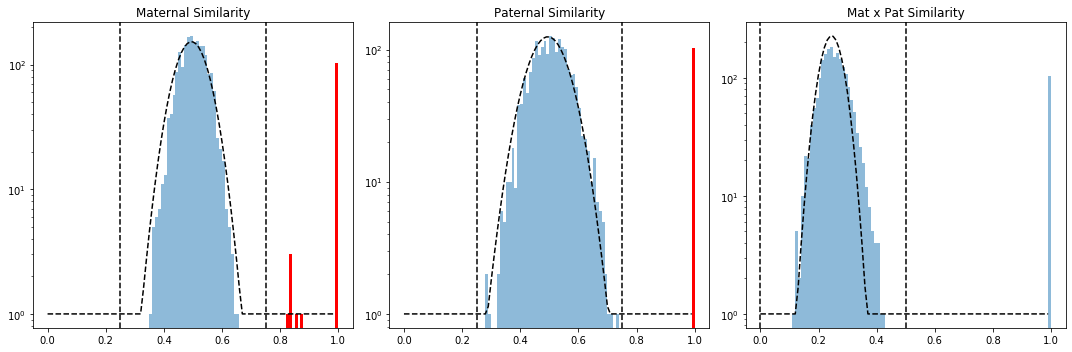

In [58]:
bins = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Maternal Similarity')
plt.hist(mat_scores, alpha=0.5, bins=bins, log=True)
plt.hist(mat_scores[mat_scores<0.25], color='red', bins=bins, log=True)
plt.hist(mat_scores[mat_scores>0.75], color='red', bins=bins, log=True)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(mat_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.title('Paternal Similarity')
plt.hist(pat_scores, alpha=0.5, bins=bins, log=True)
plt.hist(pat_scores[pat_scores<0.25], color='red', bins=bins, log=True)
plt.hist(pat_scores[pat_scores>0.75], color='red', bins=bins, log=True)

n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(pat_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.title('Mat x Pat Similarity')
plt.hist(both_scores, alpha=0.5, bins=bins, log=True)

n = 2*28 + 2*42
p = 0.25
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(both_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.0, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')

plt.tight_layout()
plt.show()

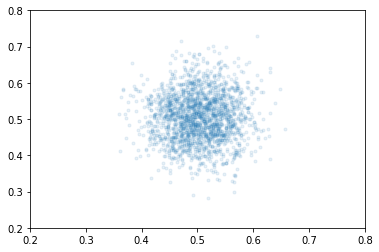

In [59]:
plt.scatter(mat_scores, pat_scores, alpha=0.1, marker='.')
plt.xlim([0.2, 0.8])
plt.ylim([0.2, 0.8])

plt.show()

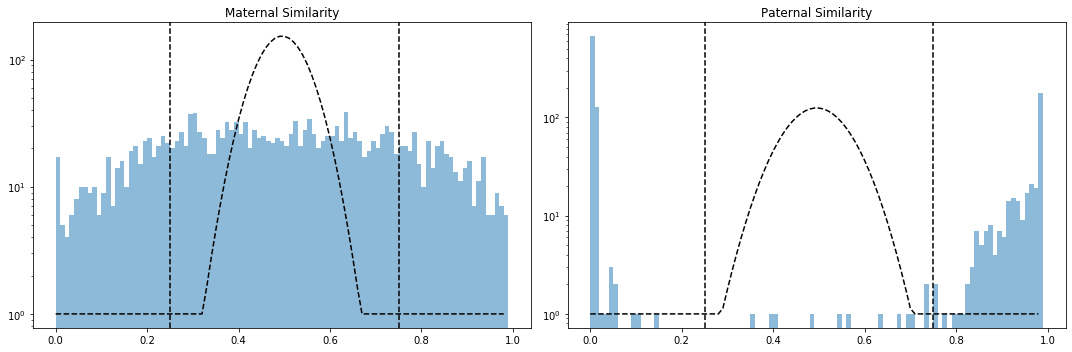

In [60]:
bins = np.arange(0, 1, 0.01)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Maternal Similarity')
plt.hist(chrom_mat_scores[-1], alpha=0.5, bins=bins, log=True)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(chrom_mat_scores[-1])*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.title('Paternal Similarity')
plt.hist(chrom_pat_scores[-1], alpha=0.5, bins=bins, log=True)

n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(chrom_pat_scores[-1])*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.tight_layout()
plt.show()